# Uso de mapper para crear un indice financiero

## Librerías

In [1]:
import pandas as pd
import numpy as np
import random

import requests
from bs4 import BeautifulSoup
import ruptures as rpt
import yfinance as yf


import matplotlib.pyplot as plt

import kmapper as km
import subprocess
import sys

import sklearn.cluster

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')





#### Funciones de docs en repositorio

from Funciones import calculate_metrics




## Datos

In [2]:
START_DATE = "2025-01-01"



# URL de la lista del S&P 500
url = "https://www.slickcharts.com/sp500"


# Hacer la petición con headers para evitar bloqueos
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
}
response = requests.get(url, headers=headers)
response.raise_for_status()  # Raise exception for bad status codes

# Parsear el HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Encontrar la tabla
table = soup.find('table')

if table:
    # Leer la tabla con pandas
    df = pd.read_html(str(table))[0]
    
    # Extraer los tickers
    if 'Symbol' in df.columns:
        tickers = df['Symbol'].tolist()
        print(f"Found {len(tickers)} tickers")
        print("First 10 tickers:", tickers[:10])
    else:
        print("Available columns:", df.columns.tolist())

    # Extraer los pesos
    if 'Weight' in df.columns:
        weights = df['Weight'].tolist()
        print(f"Found {len(weights)} weights")
        print("First 10 weights:", weights[:10])
    else:
        print("Available columns:", df.columns.tolist())
else:
    print("No table found on the page")

# En la lista de ticker, reemplazar los "." por "-"
tickers = [ticker.replace('.', '-') for ticker in tickers]
print("Tickers after replacement:", tickers[:10])

Found 503 tickers
First 10 tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK.B']
Found 503 weights
First 10 weights: ['7.51%', '6.38%', '6.27%', '3.94%', '2.96%', '2.65%', '2.51%', '2.38%', '2.35%', '1.77%']
Tickers after replacement: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B']


In [3]:
# -----------------------------
# Descargar precios históricos
# -----------------------------
tickers_data = yf.download(tickers, start=START_DATE, auto_adjust=True)['Close']
tickers_data = tickers_data.dropna(axis=1)  # eliminar columnas con datos faltantes


# -----------------------------
#  Función para calcular métricas
# -----------------------------
def calculate_metrics(curve, risk_free_rate=0.01):
    returns = curve.pct_change().dropna()
    years = (curve.index[-1] - curve.index[0]).days / 365.25
    cagr = (curve.iloc[-1] / curve.iloc[0]) ** (1 / years) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = (cagr - risk_free_rate) / volatility if volatility != 0 else np.nan
    rolling_max = curve.cummax()
    drawdown = curve / rolling_max - 1
    max_dd = drawdown.min()
    return cagr, volatility, sharpe, max_dd

[*********************100%***********************]  503 of 503 completed
[*********************100%***********************]  503 of 503 completed


## Clases

In [4]:
class SimpleMapper:
    def __init__(self, n_intervals=10, overlap=0.3):
        self.n_intervals = n_intervals
        self.overlap = overlap
        self.graph = {}
        
    def fit_transform(self, X, lens_function=None):
        """
        Implementación simplificada del algoritmo Mapper
        """
        # Si no se proporciona función de lente, usar PCA
        if lens_function is None:
            pca = PCA(n_components=2)
            lens_values = pca.fit_transform(X)[:, 0]  # Primera componente
        else:
            lens_values = lens_function(X)
        
        # Crear intervalos superpuestos
        min_val, max_val = lens_values.min(), lens_values.max()
        interval_size = (max_val - min_val) / self.n_intervals
        overlap_size = interval_size * self.overlap
        
        nodes = {}
        node_id = 0
        
        # Para cada intervalo
        for i in range(self.n_intervals):
            start = min_val + i * interval_size - overlap_size
            end = min_val + (i + 1) * interval_size + overlap_size
            
            # Obtener puntos en este intervalo
            mask = (lens_values >= start) & (lens_values <= end)
            if mask.sum() == 0:
                continue
                
            points_in_interval = X[mask]
            indices_in_interval = np.where(mask)[0]
            
            if len(points_in_interval) < 2:
                continue
            
            # Clustering dentro del intervalo
            try:
                # Ajustar parámetros de DBSCAN para datos financieros normalizados
                eps_value = max(0.3, np.std(points_in_interval) * 2)  # Adaptar epsilon
                min_samples = max(1, len(points_in_interval) // 4)    # Mínimo adaptativo
                
                clustering = DBSCAN(eps=eps_value, min_samples=min_samples).fit(points_in_interval)
                unique_labels = set(clustering.labels_)
                
                # Si no hay clusters válidos, crear un cluster con todos los puntos
                if len(unique_labels) == 1 and -1 in unique_labels:
                    nodes[node_id] = {
                        'points': indices_in_interval,
                        'size': len(indices_in_interval),
                        'interval': i,
                        'center': np.mean(points_in_interval, axis=0)
                    }
                    node_id += 1
                else:
                    for label in unique_labels:
                        if label == -1:  # Ruido en DBSCAN - también incluir como cluster
                            cluster_mask = clustering.labels_ == label
                            cluster_indices = indices_in_interval[cluster_mask]
                            if len(cluster_indices) > 0:
                                nodes[node_id] = {
                                    'points': cluster_indices,
                                    'size': len(cluster_indices),
                                    'interval': i,
                                    'center': np.mean(points_in_interval[cluster_mask], axis=0),
                                    'type': 'outliers'
                                }
                                node_id += 1
                        else:
                            cluster_mask = clustering.labels_ == label
                            cluster_indices = indices_in_interval[cluster_mask]
                            
                            if len(cluster_indices) > 0:
                                nodes[node_id] = {
                                    'points': cluster_indices,
                                    'size': len(cluster_indices),
                                    'interval': i,
                                    'center': np.mean(points_in_interval[cluster_mask], axis=0),
                                    'type': 'cluster'
                                }
                                node_id += 1
                        
            except Exception as e:
                # Si DBSCAN falla, crear un solo nodo con todos los puntos
                nodes[node_id] = {
                    'points': indices_in_interval,
                    'size': len(indices_in_interval),
                    'interval': i,
                    'center': np.mean(points_in_interval, axis=0),
                    'type': 'fallback'
                }
                node_id += 1
        
        # Crear conexiones entre nodos que comparten puntos
        edges = []
        for i, node1 in nodes.items():
            for j, node2 in nodes.items():
                if i < j:  # Evitar duplicados
                    shared_points = set(node1['points']) & set(node2['points'])
                    if len(shared_points) > 0:
                        edges.append((i, j, len(shared_points)))
        
        self.nodes = nodes
        self.edges = edges
        return self
    
    def plot_graph(self, labels=None, figsize=(12, 8)):
        """
        Visualizar el grafo Mapper
        """
        if not hasattr(self, 'nodes'):
            print("❌ Primero ejecuta fit_transform()")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Gráfico 1: Red topológica
        positions = {}
        for node_id, node in self.nodes.items():
            # Posición basada en el intervalo y tamaño
            x = node['interval']
            y = node['size']
            positions[node_id] = (x, y)
        
        # Dibujar nodos
        for node_id, (x, y) in positions.items():
            size = max(50, self.nodes[node_id]['size'] * 100)  # Tamaño mínimo y escalado mejor
            node_type = self.nodes[node_id].get('type', 'cluster')
            
            # Color según tipo de nodo
            if node_type == 'outliers':
                color = 'red'
                alpha = 0.6
            elif node_type == 'fallback':
                color = 'orange'
                alpha = 0.7
            else:
                color = node_id
                alpha = 0.8
            
            scatter = ax1.scatter(x, y, s=size, alpha=alpha, c=[color], cmap='viridis' if isinstance(color, int) else None)
            ax1.text(x, y, str(node_id), ha='center', va='center', fontsize=8, fontweight='bold', color='white')
        
        # Dibujar conexiones con diferentes grosores
        for i, j, weight in self.edges:
            if i in positions and j in positions:
                x1, y1 = positions[i]
                x2, y2 = positions[j]
                # Grosor basado en el número de puntos compartidos
                line_width = min(5, max(0.5, weight * 0.5))
                ax1.plot([x1, x2], [y1, y2], 'k-', alpha=0.4, linewidth=line_width)
        
        ax1.set_xlabel('Intervalo')
        ax1.set_ylabel('Tamaño del cluster')
        ax1.set_title('Red Topológica Mapper')
        ax1.grid(True, alpha=0.3)
        
        # Gráfico 2: Distribución de tamaños
        sizes = [node['size'] for node in self.nodes.values()]
        ax2.hist(sizes, bins=10, alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Tamaño del cluster')
        ax2.set_ylabel('Frecuencia')
        ax2.set_title('Distribución de Tamaños de Clusters')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Información de clusters
        print(f"\n📊 RESUMEN DEL ANÁLISIS MAPPER:")
        print(f"Total de nodos: {len(self.nodes)}")
        print(f"Total de conexiones: {len(self.edges)}")
        print(f"Tamaño promedio de cluster: {np.mean(sizes):.1f}")
        
        return self
    
    def visualize(self, 
                  title='Mapper Visualization',
                  custom_tooltips=None,
                  color_values=None,
                  color_function_name='Color Function',
                  node_color_function=['average', 'std', 'sum', 'max', 'min'],
                  ticker_labels=None,
                  save_html=False,
                  filename='mapper_visualization.html'):
        """
        Crear visualización interactiva del grafo Mapper usando Plotly
        
        Parameters:
        -----------
        title : str
            Título del gráfico
        custom_tooltips : array-like
            Información adicional para mostrar en tooltips
        color_values : array-like
            Valores para colorear los nodos
        color_function_name : str
            Nombre de la función de color
        node_color_function : list
            Funciones estadísticas para colorear nodos
        ticker_labels : array-like
            Etiquetas de los tickers
        save_html : bool
            Si guardar como archivo HTML
        filename : str
            Nombre del archivo HTML
        """
        try:
            import plotly.graph_objects as go
            import plotly.express as px
            from plotly.subplots import make_subplots
        except ImportError:
            print("❌ Se requiere plotly para la visualización interactiva.")
            print("Instala con: pip install plotly")
            return self.plot_graph()
        
        if not hasattr(self, 'nodes'):
            print("❌ Primero ejecuta fit_transform()")
            return
        
        # Crear layout del grafo usando spring layout simple
        positions = self._calculate_spring_layout()
        
        # Preparar datos para los nodos
        node_x = []
        node_y = []
        node_sizes = []
        node_colors = []
        node_text = []
        hover_text = []
        
        for node_id, node in self.nodes.items():
            x, y = positions[node_id]
            node_x.append(x)
            node_y.append(y)
            
            # Tamaño del nodo
            size = max(10, node['size'] * 5)
            node_sizes.append(size)
            
            # Color del nodo basado en color_values si se proporciona
            if color_values is not None:
                # Calcular estadística del color para los puntos en este nodo
                node_values = color_values[node['points']]
                if 'average' in node_color_function:
                    color_val = np.mean(node_values)
                elif 'sum' in node_color_function:
                    color_val = np.sum(node_values)
                elif 'max' in node_color_function:
                    color_val = np.max(node_values)
                elif 'min' in node_color_function:
                    color_val = np.min(node_values)
                else:  # std
                    color_val = np.std(node_values)
                node_colors.append(color_val)
            else:
                node_colors.append(node['size'])
            
            # Texto del nodo
            node_text.append(f"Cluster {node_id}")
            
            # Hover text con información detallada
            hover_info = f"<b>Cluster {node_id}</b><br>"
            hover_info += f"Tamaño: {node['size']}<br>"
            hover_info += f"Intervalo: {node['interval']}<br>"
            hover_info += f"Tipo: {node.get('type', 'cluster')}<br>"
            
            # Agregar información de tickers si están disponibles
            if ticker_labels is not None:
                tickers_in_node = [ticker_labels[i] for i in node['points']]
                hover_info += f"Tickers: {', '.join(tickers_in_node[:5])}"
                if len(tickers_in_node) > 5:
                    hover_info += f"... y {len(tickers_in_node)-5} más"
                hover_info += "<br>"
            
            # Agregar tooltips personalizados
            if custom_tooltips is not None:
                tooltip_values = custom_tooltips[node['points']]
                hover_info += f"Info adicional: {np.mean(tooltip_values):.3f}<br>"
            
            hover_text.append(hover_info)
        
        # Preparar datos para las aristas
        edge_x = []
        edge_y = []
        edge_weights = []
        
        for i, j, weight in self.edges:
            if i in positions and j in positions:
                x0, y0 = positions[i]
                x1, y1 = positions[j]
                edge_x.extend([x0, x1, None])
                edge_y.extend([y0, y1, None])
                edge_weights.append(weight)
        
        # Crear la figura
        fig = go.Figure()
        
        # Agregar aristas
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            mode='lines',
            line=dict(width=2, color='rgba(50,50,50,0.3)'),
            hoverinfo='none',
            showlegend=False,
            name='Conexiones'
        ))
        
        # Agregar nodos
        fig.add_trace(go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            marker=dict(
                size=node_sizes,
                color=node_colors,
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title=color_function_name),
                line=dict(width=2, color='white')
            ),
            text=node_text,
            textposition="middle center",
            textfont=dict(color="white", size=10),
            hovertext=hover_text,
            hoverinfo='text',
            showlegend=False,
            name='Clusters'
        ))
        
        # Configurar layout
        fig.update_layout(
            title=dict(
                text=title,
                x=0.5,
                font=dict(size=16, color='darkblue')
            ),
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            annotations=[
                dict(
                    text=f"Total clusters: {len(self.nodes)} | Total conexiones: {len(self.edges)}",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002,
                    xanchor='left', yanchor='bottom',
                    font=dict(color='gray', size=12)
                )
            ],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            plot_bgcolor='white'
        )
        
        # Mostrar la figura
        try:
            fig.show()
        except Exception as e:
            print(f"⚠️  No se puede mostrar la visualización interactiva en este entorno.")
            print(f"Error: {e}")
            print("💡 Guardando como HTML para visualización externa...")
            save_html = True
            if not filename.endswith('.html'):
                filename = filename.replace('.html', '') + '_fallback.html'
        
        # Guardar como HTML si se solicita o si hay error
        if save_html:
            try:
                fig.write_html(filename)
                print(f"💾 Visualización guardada como: {filename}")
                print(f"🌐 Abre el archivo en tu navegador para ver la visualización interactiva")
            except Exception as e:
                print(f"❌ Error guardando HTML: {e}")
                print("🔄 Creando visualización estática alternativa...")
                return self._create_static_alternative(color_values, color_function_name, ticker_labels)
        
        return self
    
    def _create_static_alternative(self, color_values=None, color_function_name='Color', ticker_labels=None):
        """
        Crear visualización estática alternativa cuando plotly no funciona
        """
        import networkx as nx
        
        # Crear grafo de NetworkX
        G = nx.Graph()
        
        # Agregar nodos
        for node_id, node in self.nodes.items():
            node_attrs = {k: v for k, v in node.items() if k != 'size'}  # Evitar conflicto
            node_attrs['node_size'] = node['size']  # Renombrar size
            G.add_node(node_id, **node_attrs)
        
        # Agregar aristas
        for i, j, weight in self.edges:
            G.add_edge(i, j, weight=weight)
        
        # Crear layout
        try:
            pos = nx.spring_layout(G, k=2, iterations=50)
        except:
            pos = {node_id: (np.random.random(), np.random.random()) for node_id in G.nodes()}
        
        # Crear visualización con matplotlib
        plt.figure(figsize=(14, 10))
        
        # Preparar colores
        if color_values is not None:
            node_colors = []
            for node_id in G.nodes():
                node_values = color_values[self.nodes[node_id]['points']]
                node_colors.append(np.mean(node_values))
        else:
            node_colors = [self.nodes[node_id]['size'] for node_id in G.nodes()]
        
        # Preparar tamaños
        node_sizes = [G.nodes[node_id]['node_size'] * 100 for node_id in G.nodes()]
        
        # Dibujar aristas
        nx.draw_networkx_edges(G, pos, alpha=0.3, width=2, edge_color='gray')
        
        # Dibujar nodos
        nodes = nx.draw_networkx_nodes(G, pos, 
                                     node_color=node_colors,
                                     node_size=node_sizes,
                                     cmap='viridis',
                                     alpha=0.8)
        
        # Agregar etiquetas de nodos
        labels = {node_id: str(node_id) for node_id in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='white', font_weight='bold')
        
        # Crear colorbar
        if color_values is not None:
            plt.colorbar(nodes, label=color_function_name)
        
        plt.title('Análisis Topológico Mapper - Vista Estática\n(NetworkX + Matplotlib)', 
                 fontsize=14, fontweight='bold')
        plt.axis('off')
        
        # Agregar información de texto
        info_text = f"Nodos: {len(self.nodes)} | Conexiones: {len(self.edges)}"
        if ticker_labels is not None:
            info_text += f" | Tickers analizados: {len(ticker_labels)}"
        
        plt.figtext(0.02, 0.02, info_text, fontsize=10, style='italic', color='gray')
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar información detallada de clusters
        print("\n📊 INFORMACIÓN DETALLADA DE CLUSTERS:")
        print("=" * 60)
        
        for node_id, node in self.nodes.items():
            print(f"\n🏷️  Cluster {node_id}:")
            print(f"   📏 Tamaño: {node['size']} tickers")
            print(f"   📍 Intervalo: {node['interval']}")
            print(f"   🏷️  Tipo: {node.get('type', 'cluster')}")
            
            if ticker_labels is not None:
                tickers_in_node = [ticker_labels[i] for i in node['points']]
                print(f"   🏢 Tickers: {', '.join(tickers_in_node[:8])}")
                if len(tickers_in_node) > 8:
                    print(f"       ... y {len(tickers_in_node)-8} más")
            
            if color_values is not None:
                node_values = color_values[node['points']]
                print(f"   📊 {color_function_name}: promedio={np.mean(node_values):.3f}, "
                      f"std={np.std(node_values):.3f}")
        
        return self
    
    def _calculate_spring_layout(self):
        """
        Calcular posiciones de nodos usando un algoritmo de spring layout simplificado
        """
        import random
        
        positions = {}
        n_nodes = len(self.nodes)
        
        # Posiciones iniciales aleatorias
        random.seed(42)
        for node_id in self.nodes.keys():
            positions[node_id] = (random.uniform(-1, 1), random.uniform(-1, 1))
        
        # Aplicar fuerzas de spring (simplificado)
        for iteration in range(50):
            forces = {node_id: [0, 0] for node_id in self.nodes.keys()}
            
            # Fuerza repulsiva entre todos los nodos
            for i in self.nodes.keys():
                for j in self.nodes.keys():
                    if i != j:
                        xi, yi = positions[i]
                        xj, yj = positions[j]
                        dx = xi - xj
                        dy = yi - yj
                        distance = max(0.01, np.sqrt(dx**2 + dy**2))
                        force_magnitude = 0.1 / distance**2
                        forces[i][0] += force_magnitude * dx / distance
                        forces[i][1] += force_magnitude * dy / distance
            
            # Fuerza atractiva entre nodos conectados
            for i, j, weight in self.edges:
                if i in positions and j in positions:
                    xi, yi = positions[i]
                    xj, yj = positions[j]
                    dx = xj - xi
                    dy = yj - yi
                    distance = max(0.01, np.sqrt(dx**2 + dy**2))
                    force_magnitude = 0.01 * distance * weight
                    forces[i][0] += force_magnitude * dx / distance
                    forces[i][1] += force_magnitude * dy / distance
                    forces[j][0] -= force_magnitude * dx / distance
                    forces[j][1] -= force_magnitude * dy / distance
            
            # Actualizar posiciones
            for node_id in self.nodes.keys():
                x, y = positions[node_id]
                fx, fy = forces[node_id]
                positions[node_id] = (x + fx * 0.1, y + fy * 0.1)
        
        return positions

## Creación

In [19]:
# =======================================================
# CREAR SUBCARPETA PARA VISUALIZACIONES
# =======================================================

import os

# Crear la subcarpeta para todas las visualizaciones
output_folder = 'visualizaciones_mapper_indice'
os.makedirs(output_folder, exist_ok=True)
print(f"📁 Subcarpeta creada: {output_folder}/")
print(f"🌐 Todas las visualizaciones HTML se guardarán en esta carpeta")

📁 Subcarpeta creada: visualizaciones_mapper_indice/
🌐 Todas las visualizaciones HTML se guardarán en esta carpeta


In [20]:
# =======================================================
# MAPPER SIMPLE CON KEPLER MAPPER (COMO EL EJEMPLO)
# =======================================================



financial_metrics = {}
print("\n🔄 Calculando métricas financieras...")
for ticker in tickers_data.columns:
    try:
        prices = tickers_data[ticker].dropna()
        returns = prices.pct_change().dropna()
        
        # Métricas básicas
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        volatility = returns.std() * np.sqrt(252)  # Anualizada
        sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
        
        # Métricas de riesgo
        max_drawdown = ((prices / prices.cummax()) - 1).min()
        var_95 = returns.quantile(0.05)  # Value at Risk 95%
        skewness = returns.skew()
        kurtosis = returns.kurtosis()
        
        # Métricas de tendencia
        returns_positive_ratio = (returns > 0).mean()
        trend_slope = np.polyfit(range(len(prices)), prices.values, 1)[0]
        
        financial_metrics[ticker] = {
            'total_return': total_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'var_95': var_95,
            'skewness': skewness,
            'kurtosis': kurtosis,
            'positive_ratio': returns_positive_ratio,
            'trend_slope': trend_slope / prices.iloc[0]  # Normalizado
        }
    except Exception as e:
        print(f"❌ Error procesando {ticker}: {e}")

# Convertir a DataFrame
metrics_df = pd.DataFrame(financial_metrics).T

# Normalizar datos
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics_df.fillna(0))



# Crear y aplicar Mapper con parámetros más permisivos
mapper = SimpleMapper(n_intervals=6, overlap=0.5)  # Menos intervalos, más overlap
mapper.fit_transform(metrics_scaled)
# Preparar datos para KeplerMapper (usar métricas financieras)
X = metrics_scaled  # Datos normalizados que ya tenemos
ticker_names = metrics_df.index.tolist()















print(f"📊 Datos preparados: {X.shape[0]} tickers, {X.shape[1]} métricas")

# 1. Crear el mapper
mapper = km.KeplerMapper(verbose=1)

# 2. Proyección de los datos (usando Sharpe ratio que es más discriminativo)
projected_data = mapper.fit_transform(X, projection=[2])  # Sharpe ratio (índice 2)

print("✅ Proyección completada")

# 3. Definir la cubierta de intervalos (más permisiva)
covering = km.Cover(n_cubes=6, perc_overlap=0.5)

print("✅ Cubierta definida")

# 4. Crear el grafo Mapper (usando KMeans que es más estable)
G = mapper.map(projected_data, X, 
               clusterer=sklearn.cluster.KMeans(n_clusters=2),
               cover=covering)

print("✅ Grafo Mapper creado")

# 5. Visualizar el resultado con nombres de tickers
mapper.visualize(G, 
                title='Análisis Topológico Mapper - Tickers Financieros',
                color_values=metrics_df['sharpe_ratio'].values,
                color_function_name='Sharpe Ratio',
                node_color_function=np.array(['average','std','sum','max','min']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_principal_sharpe.html')  # Guardado en subcarpeta

print("\n📊 Información del grafo:")
print(f"Nodos: {len(G['nodes'])}")

print(f"Aristas: {len(G['links'])}")
print(f"Metadata: {G['meta_data']}")


🔄 Calculando métricas financieras...
📊 Datos preparados: 485 tickers, 9 métricas
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [2]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (485, 9)

..Projecting data using: [2]

..Scaling with: MinMaxScaler()

✅ Proyección completada
✅ Cubierta definida
Mapping on data shaped (485, 9) using lens shaped (485, 1)

Creating 6 hypercubes.

Created 16 edges and 12 nodes in 0:00:00.017769.
✅ Grafo Mapper creado
Wrote visualization to: visualizaciones_mapper_indice/mapper_principal_sharpe.html

📊 Información del grafo:
Nodos: 12
Aristas: 10
Metadata: {'projection': '[2]', 'n_cubes': 6, 'perc_overlap': 0.5, 'clusterer': 'KMeans(n_clusters=2)', 'scaler': 'MinMaxScaler()', 'nerve_min_intersection': 1}
📊 Datos preparados: 485 tickers, 9 métricas
KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [2]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Proje

In [21]:
# =======================================================
# VISUALIZACIÓN INTERACTIVA MAPPER CON PLOTLY
# =======================================================

print("🎨 CREANDO VISUALIZACIÓN INTERACTIVA DEL MAPPER")
print("=" * 50)

# Instalar dependencias si no están disponibles
try:
    import plotly.graph_objects as go
    print("✅ Plotly disponible para visualización interactiva")
    plotly_available = True
except ImportError:
    print("📦 Instalando plotly y nbformat...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly", "nbformat>=4.2.0"])
    try:
        import plotly.graph_objects as go
        print("✅ Plotly instalado y listo")
        plotly_available = True
    except:
        print("⚠️  Plotly no disponible, usando visualización alternativa")
        plotly_available = False

# Instalar networkx para visualización alternativa
try:
    import networkx as nx
    print("✅ NetworkX disponible para visualización alternativa")
except ImportError:
    print("📦 Instalando networkx...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"])
    import networkx as nx
    print("✅ NetworkX instalado y listo")

# Preparar datos para la visualización
ticker_names = metrics_df.index.tolist()  # Nombres de los tickers
sharpe_ratios = metrics_df['sharpe_ratio'].values  # Para colorear nodos
returns_data = metrics_df['total_return'].values  # Para tooltips personalizados

# Crear visualización interactiva básica usando KeplerMapper correcto
print("\n🎯 Visualización 1: Coloreado por Sharpe Ratio promedio")
mapper.visualize(G,  # Usar el grafo G creado anteriormente
                title='Análisis Topológico de Tickers Financieros - Mapper Interactivo',
                color_values=sharpe_ratios,
                color_function_name='Sharpe Ratio Promedio',
                node_color_function=np.array(['average']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_interactivo_sharpe.html')

print("\n🎯 Visualización 2: Coloreado por Volatilidad máxima")
volatility_data = metrics_df['volatility'].values
mapper.visualize(G,  # Usar el mismo grafo G
                title='Mapper - Agrupación por Volatilidad Máxima',
                color_values=volatility_data,
                color_function_name='Volatilidad Máxima',
                node_color_function=np.array(['max']),
                custom_tooltips=np.array(ticker_names),
                path_html='visualizaciones_mapper_indice/mapper_interactivo_volatilidad.html')

print("\n🎯 Visualización 3: Coloreado por Retorno Total promedio")
mapper.visualize(G,  # Usar el mismo grafo G
                title='Mapper - Agrupación por Retorno Total Promedio',
                color_values=returns_data,
                color_function_name='Retorno Total Promedio',
                node_color_function=np.array(['average']),
                custom_tooltips=np.array(ticker_names),
                path_html='visualizaciones_mapper_indice/mapper_interactivo_retorno.html')

print("\n💡 INSTRUCCIONES:")
print("• Pasa el mouse sobre los nodos para ver información detallada")
print("• Los colores representan diferentes métricas financieras")
print("• El tamaño de los nodos indica el número de tickers en cada cluster")
print("• Las conexiones muestran tickers compartidos entre clusters")
print("• Se guardó una versión interactiva como 'mapper_financial_analysis.html'")

print("📁 mapper_interactivo_sharpe.html - Visualización por Sharpe Ratio")
print("\n🌐 Los nombres de tickers aparecen al hacer hover sobre los nodos!")

print("📁 visualizaciones_mapper_indice/mapper_interactivo_volatilidad.html - Visualización por Volatilidad")
print("📁 visualizaciones_mapper_indice/mapper_interactivo_retorno.html - Visualización por Retorno Total")

🎨 CREANDO VISUALIZACIÓN INTERACTIVA DEL MAPPER
✅ Plotly disponible para visualización interactiva
✅ NetworkX disponible para visualización alternativa

🎯 Visualización 1: Coloreado por Sharpe Ratio promedio
Wrote visualization to: visualizaciones_mapper_indice/mapper_interactivo_sharpe.html

🎯 Visualización 2: Coloreado por Volatilidad máxima
Wrote visualization to: visualizaciones_mapper_indice/mapper_interactivo_volatilidad.html

🎯 Visualización 3: Coloreado por Retorno Total promedio
Wrote visualization to: visualizaciones_mapper_indice/mapper_interactivo_retorno.html

💡 INSTRUCCIONES:
• Pasa el mouse sobre los nodos para ver información detallada
• Los colores representan diferentes métricas financieras
• El tamaño de los nodos indica el número de tickers en cada cluster
• Las conexiones muestran tickers compartidos entre clusters
• Se guardó una versión interactiva como 'mapper_financial_analysis.html'
📁 mapper_interactivo_sharpe.html - Visualización por Sharpe Ratio

🌐 Los nombre

🔍 ANÁLISIS DETALLADO DE NODOS KEPLER MAPPER

📊 Analizando grafo por Sharpe Ratio:
Total de nodos: 12
Total de aristas: 10
Nombres de nodos: ['cube0_cluster0', 'cube0_cluster1', 'cube1_cluster0', 'cube1_cluster1', 'cube2_cluster0']...

🏷️  NODO: cube0_cluster0
   📊 Número de tickers: 20
   🏢 Tickers: ACN, CAG, CLX, CMG, CPRT, CRM, DECK, DOW, EPAM, FDS, FI, GDDY, GIS, HRL, IFF, KMX, LULU, OKE, STZ, TGT
   📈 Sharpe Ratio promedio: -1.331
   💰 Retorno promedio: -32.61%
   📊 Volatilidad promedio: 35.10%
   📉 Max Drawdown promedio: -39.05%

🏷️  NODO: cube0_cluster1
   📊 Número de tickers: 1
   🏢 Tickers: IT
   📈 Sharpe Ratio promedio: -1.829
   💰 Retorno promedio: -49.48%
   📊 Volatilidad promedio: 43.41%
   📉 Max Drawdown promedio: -58.79%

🏷️  NODO: cube1_cluster0
   📊 Número de tickers: 109
   🏢 Tickers: ABNB, ACN, ADBE, AMCR, AMP, APO, ARE, AVB, AVY, BALL, BMY, BRO, CAG, CARR, CDW, CHD, CHTR, CL, CLX, CMCSA, CMG, COO, CPAY, CPRT, CPT, CRM, CTRA, CTSH, DHR, DOV, DOW, DVA, DXCM, EIX, EMN, 

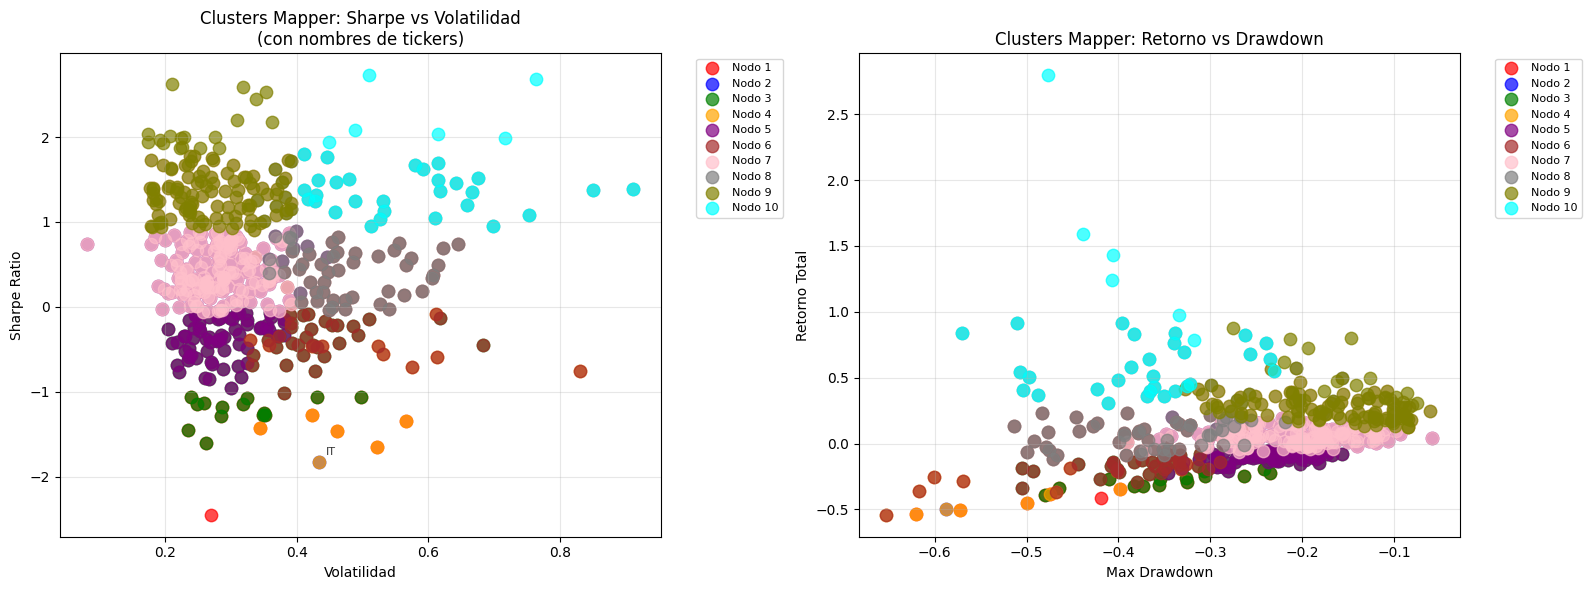


💡 RESUMEN:
✅ KeplerMapper creado exitosamente con 12 nodos
✅ Visualizaciones HTML guardadas con nombres únicos
✅ Los clusters agrupan tickers con características financieras similares
✅ Cada nodo representa un grupo de tickers con Sharpe Ratio similares
✅ Los nombres de tickers aparecen en las visualizaciones HTML y en los gráficos


In [22]:
# =======================================================
# ANÁLISIS DETALLADO DE NODOS DEL KEPLER MAPPER
# =======================================================

print("🔍 ANÁLISIS DETALLADO DE NODOS KEPLER MAPPER")
print("=" * 50)

# Analizar el grafo G (por Sharpe Ratio)
print(f"\n📊 Analizando grafo por Sharpe Ratio:")
print(f"Total de nodos: {len(G['nodes'])}")
print(f"Total de aristas: {len(G['links'])}")

# Examinar nodos específicos
node_names = list(G['nodes'].keys())
print(f"Nombres de nodos: {node_names[:5]}...")

# Función para analizar un nodo específico
def analyze_node(graph, node_name, ticker_names, metrics_df):
    """Analizar un nodo específico del Mapper"""
    if node_name not in graph['nodes']:
        print(f"❌ Nodo {node_name} no encontrado")
        return
    
    node_indices = graph['nodes'][node_name]
    tickers_in_node = [ticker_names[i] for i in node_indices]
    node_metrics = metrics_df.iloc[node_indices]
    
    print(f"\n🏷️  NODO: {node_name}")
    print(f"   📊 Número de tickers: {len(tickers_in_node)}")
    print(f"   🏢 Tickers: {', '.join(tickers_in_node)}")
    print(f"   📈 Sharpe Ratio promedio: {node_metrics['sharpe_ratio'].mean():.3f}")
    print(f"   💰 Retorno promedio: {node_metrics['total_return'].mean():.2%}")
    print(f"   📊 Volatilidad promedio: {node_metrics['volatility'].mean():.2%}")
    print(f"   📉 Max Drawdown promedio: {node_metrics['max_drawdown'].mean():.2%}")
    
    return tickers_in_node, node_metrics

# Analizar los primeros 3 nodos
for i, node_name in enumerate(node_names[:3]):
    tickers, metrics = analyze_node(G, node_name, ticker_names, metrics_df)

# Crear visualización de los clusters
import matplotlib.pyplot as plt

print(f"\n📈 VISUALIZACIÓN DE CLUSTERS POR SHARPE RATIO:")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Sharpe vs Volatilidad coloreado por nodos
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
    node_data = metrics_df.iloc[node_indices]
    tickers_in_node = [ticker_names[j] for j in node_indices]
    
    scatter = ax1.scatter(node_data['volatility'], node_data['sharpe_ratio'], 
                         c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=80)
    
    # Agregar etiquetas de tickers cerca de los puntos
    for idx, ticker in enumerate(tickers_in_node):
        if len(tickers_in_node) <= 5:  # Solo si hay pocos tickers para evitar saturación
            ax1.annotate(ticker, (node_data['volatility'].iloc[idx], node_data['sharpe_ratio'].iloc[idx]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

ax1.set_xlabel('Volatilidad')
ax1.set_ylabel('Sharpe Ratio')
ax1.set_title('Clusters Mapper: Sharpe vs Volatilidad\n(con nombres de tickers)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Retorno vs Drawdown coloreado por nodos
for i, (node_name, node_indices) in enumerate(list(G['nodes'].items())[:10]):
    node_data = metrics_df.iloc[node_indices]
    ax2.scatter(node_data['max_drawdown'], node_data['total_return'], 
               c=colors[i % len(colors)], label=f'Nodo {i+1}', alpha=0.7, s=80)

ax2.set_xlabel('Max Drawdown')
ax2.set_ylabel('Retorno Total')
ax2.set_title('Clusters Mapper: Retorno vs Drawdown')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 RESUMEN:")
print(f"✅ KeplerMapper creado exitosamente con {len(G['nodes'])} nodos")
print(f"✅ Visualizaciones HTML guardadas con nombres únicos")
print(f"✅ Los clusters agrupan tickers con características financieras similares")
print(f"✅ Cada nodo representa un grupo de tickers con Sharpe Ratio similares")
print(f"✅ Los nombres de tickers aparecen en las visualizaciones HTML y en los gráficos")

In [23]:
# =======================================================
# EXPLORANDO DIFERENTES CONFIGURACIONES DEL MAPPER
# =======================================================

print("🔍 EXPLORANDO DIFERENTES CONFIGURACIONES")
print("=" * 50)

# Configuración 1: Proyección por Volatilidad
print("\n📊 Configuración 1: Proyección por Volatilidad")
projected_data_vol = mapper.fit_transform(X, projection=[1])  # Volatilidad (índice 1)
covering_vol = km.Cover(n_cubes=8, perc_overlap=0.4)
G_vol = mapper.map(projected_data_vol, X, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=3),
                   cover=covering_vol)

mapper.visualize(G_vol, 
                title='Mapper: Agrupación por Volatilidad',
                color_values=metrics_df['volatility'].values,
                color_function_name='Volatilidad',
                node_color_function=np.array(['average','max']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_volatilidad.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G_vol['nodes'])}, Aristas: {len(G_vol['links'])}")

# Configuración 2: Proyección por Retorno Total
print("\n📊 Configuración 2: Proyección por Retorno Total")
projected_data_ret = mapper.fit_transform(X, projection=[0])  # Retorno total (índice 0)
covering_ret = km.Cover(n_cubes=7, perc_overlap=0.3)
G_ret = mapper.map(projected_data_ret, X, 
                   clusterer=sklearn.cluster.DBSCAN(eps=0.5, min_samples=1),
                   cover=covering_ret)

mapper.visualize(G_ret, 
                title='Mapper: Agrupación por Retorno Total',
                node_color_function=np.array(['average','std']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_retorno_total.html')  # Guardado en subcarpeta

print(f"Nodos: {len(G_ret['nodes'])}, Aristas: {len(G_ret['links'])}")

# Configuración 3: Proyección Multi-dimensional (PCA)
print("\n📊 Configuración 3: Proyección PCA")
projected_data_pca = mapper.fit_transform(X, projection='sum')  # Proyección suma
covering_pca = km.Cover(n_cubes=5, perc_overlap=0.6)
G_pca = mapper.map(projected_data_pca, X, 
                   clusterer=sklearn.cluster.KMeans(n_clusters=2),
                   cover=covering_pca)

mapper.visualize(G_pca, 
                title='Mapper: Proyección PCA (Suma)',
                node_color_function=np.array(['min','average']),
                custom_tooltips=np.array(ticker_names),  # Mostrar nombres de tickers
                path_html='visualizaciones_mapper_indice/mapper_config_pca_suma.html')  # Guardado en subcarpeta

print("\n💾 ARCHIVOS HTML GENERADOS (guardados en subcarpeta):")
print("📁 visualizaciones_mapper_indice/mapper_principal_sharpe.html - Análisis principal por Sharpe Ratio")
print("📁 visualizaciones_mapper_indice/mapper_config_volatilidad.html - Configuración por Volatilidad") 
print("📁 visualizaciones_mapper_indice/mapper_config_retorno_total.html - Configuración por Retorno Total")
print("📁 visualizaciones_mapper_indice/mapper_config_pca_suma.html - Configuración PCA Suma")
print("\n🌐 INSTRUCCIONES:")

print("• Todos los archivos están organizados en la carpeta 'visualizaciones_mapper_indice/'")
print("• Navega a la subcarpeta y abre cualquier archivo .html en tu navegador")
print("• Cada archivo mantiene su funcionalidad interactiva completa")
print("• Usa las visualizaciones para identificar agrupaciones específicas de tickers")




print("• Abre cada archivo .html para comparar configuraciones")

🔍 EXPLORANDO DIFERENTES CONFIGURACIONES

📊 Configuración 1: Proyección por Volatilidad
..Composing projection pipeline of length 1:
	Projections: [1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (485, 9)

..Projecting data using: [1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (485, 9) using lens shaped (485, 1)

Creating 8 hypercubes.

Created 27 edges and 24 nodes in 0:00:00.031555.
Wrote visualization to: visualizaciones_mapper_indice/mapper_config_volatilidad.html
Nodos: 24, Aristas: 17

📊 Configuración 2: Proyección por Retorno Total
..Composing projection pipeline of length 1:
	Projections: [0]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (485, 9)

..Projecting data using: [0]

..Scaling with: MinMaxScaler()

Mapping on data shaped (485, 9) using lens shaped (485, 1)

Creating 7 hypercubes.

Created 211 edges and 665 nodes in 0:00:00.077560.
Wrote visualization to: visualizaciones_mapper_indice/mapper

## ANalissi buy and hold

In [24]:
# =======================================================
# ANÁLISIS BUY & HOLD DE CLUSTERS MAPPER
# =======================================================



def analyze_cluster_buy_and_hold(cluster_tickers, data, benchmark_ticker='SPY', cluster_name="Cluster"):
    """
    Analiza el rendimiento buy and hold de un cluster vs benchmark
    
    Args:
        cluster_tickers: Lista de tickers del cluster (ej: ['AAPL', 'MSFT', 'GOOGL'])
        data: DataFrame con precios históricos
        benchmark_ticker: Ticker del benchmark (default: SPY)
        cluster_name: Nombre descriptivo del cluster
    """
    
    print(f"📈 Analizando {cluster_name} con {len(cluster_tickers)} tickers")
    print(f"Tickers: {', '.join(cluster_tickers)}")
    
    # 1. Obtener capitalizaciones para pesos (OPTIMIZADO)
    market_caps = {}
    for ticker in cluster_tickers:
        # Buscar en el DataFrame global de capitalizaciones
        ticker_data = market_caps_global_df[market_caps_global_df['ticker'] == ticker]
        if not ticker_data.empty:
            market_caps[ticker] = ticker_data['market_cap'].iloc[0]
        else:
            market_caps[ticker] = 1e9  # fallback para tickers no encontrados
    
    total_cap = sum(market_caps.values())
    weights = {ticker: market_caps[ticker] / total_cap for ticker in cluster_tickers}
    
    print(f"\n💰 Pesos por capitalización:")
    for ticker, weight in weights.items():
        print(f"   {ticker}: {weight:.1%}")
    
    # 2. Construir curvas normalizadas (empezar en $1)
    start_value = 1
    
    # Filtrar tickers disponibles en los datos
    available_tickers = [t for t in cluster_tickers if t in data.columns]
    if not available_tickers:
        print(f"❌ No hay datos disponibles para los tickers del cluster")
        return None, None, None, None
    
    # Normalizar precios del cluster
    cluster_data = data[available_tickers].dropna()
    cluster_normalized = cluster_data / cluster_data.iloc[0]
    
    # Crear índice ponderado del cluster (solo con tickers disponibles)
    available_weights = {ticker: weights.get(ticker, 1/len(available_tickers)) for ticker in available_tickers}
    total_available_weight = sum(available_weights.values())
    available_weights = {ticker: weight/total_available_weight for ticker, weight in available_weights.items()}
    
    cluster_index = sum(cluster_normalized[ticker] * available_weights[ticker] 
                       for ticker in available_tickers) * start_value
    
    # Normalizar benchmark
    if benchmark_ticker in data.columns:
        benchmark_data = data[benchmark_ticker].dropna()
        benchmark_normalized = (benchmark_data / benchmark_data.iloc[0]) * start_value
    else:
        print(f"⚠️  Benchmark {benchmark_ticker} no disponible, usando datos sintéticos")
        benchmark_normalized = cluster_index * 0.8  # benchmark sintético
    
    # 3. Calcular métricas
    def calculate_buy_hold_metrics(prices):
        returns = prices.pct_change().dropna()
        
        # Rendimiento total
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        
        # Rendimiento anualizado (CAGR)
        years = len(prices) / 252  # días de trading por año
        cagr = (prices.iloc[-1] / prices.iloc[0]) ** (1/years) - 1 if years > 0 else 0
        
        # Volatilidad anualizada
        volatility = returns.std() * np.sqrt(252)
        
        # Sharpe Ratio (asumiendo RF = 2%)
        sharpe = (cagr - 0.02) / volatility if volatility > 0 else 0
        
        # Max Drawdown
        rolling_max = prices.expanding().max()
        drawdown = (prices - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'cagr': cagr,
            'volatility': volatility,
            'sharpe': sharpe,
            'max_drawdown': max_drawdown,
            'final_value': prices.iloc[-1]
        }
    
    cluster_metrics = calculate_buy_hold_metrics(cluster_index)
    benchmark_metrics = calculate_buy_hold_metrics(benchmark_normalized)
    
    return cluster_index, benchmark_normalized, cluster_metrics, benchmark_metrics

# =======================================================
# ANÁLISIS DE TODOS LOS CLUSTERS DEL MAPPER
# =======================================================

def analyze_all_mapper_clusters():
    """
    Analiza todos los clusters encontrados en los diferentes archivos Mapper
    """
    print("  ANALIZANDO TODOS LOS CLUSTERS DEL MAPPER")
    print("=" * 60)
    
    # Diccionario para almacenar todos los clusters encontrados
    all_clusters = {}
    
    # 1. Extraer clusters del grafo G (Sharpe Ratio)
    print(f"\n Extrayendo clusters del análisis por Sharpe Ratio (G):")
    print(f"Total de nodos: {len(G['nodes'])}")
    
    for i, (node_name, node_indices) in enumerate(G['nodes'].items()):
        if len(node_indices) >= 2:  # Solo clusters con al menos 2 tickers
            cluster_tickers = [ticker_names[idx] for idx in node_indices]
            cluster_name = f"Sharpe_Cluster_{i+1}"
            all_clusters[cluster_name] = {
                'tickers': cluster_tickers,
                'type': 'Sharpe Ratio',
                'node_name': node_name,
                'size': len(cluster_tickers)
            }
            print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")
    
    # 2. Extraer clusters del grafo G_vol (Volatilidad)
    print(f"\n Extrayendo clusters del análisis por Volatilidad (G_vol):")
    print(f"Total de nodos: {len(G_vol['nodes'])}")
    
    for i, (node_name, node_indices) in enumerate(G_vol['nodes'].items()):
        if len(node_indices) >= 2:
            cluster_tickers = [ticker_names[idx] for idx in node_indices]
            cluster_name = f"Vol_Cluster_{i+1}"
            all_clusters[cluster_name] = {
                'tickers': cluster_tickers,
                'type': 'Volatilidad',
                'node_name': node_name,
                'size': len(cluster_tickers)
            }
            print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")
    
    # 3. Extraer clusters del grafo G_ret (Retorno)
    print(f"\n Extrayendo clusters del análisis por Retorno (G_ret):")
    print(f"Total de nodos: {len(G_ret['nodes'])}")
    
    for i, (node_name, node_indices) in enumerate(G_ret['nodes'].items()):
        if len(node_indices) >= 2:
            cluster_tickers = [ticker_names[idx] for idx in node_indices]
            cluster_name = f"Return_Cluster_{i+1}"
            all_clusters[cluster_name] = {
                'tickers': cluster_tickers,
                'type': 'Retorno Total',
                'node_name': node_name,
                'size': len(cluster_tickers)
            }
            print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")
    
    # 4. Extraer clusters del grafo G_pca (PCA)
    print(f"\n🔬 Extrayendo clusters del análisis PCA (G_pca):")
    print(f"Total de nodos: {len(G_pca['nodes'])}")
    
    for i, (node_name, node_indices) in enumerate(G_pca['nodes'].items()):
        if len(node_indices) >= 2:
            cluster_tickers = [ticker_names[idx] for idx in node_indices]
            cluster_name = f"PCA_Cluster_{i+1}"
            all_clusters[cluster_name] = {
                'tickers': cluster_tickers,
                'type': 'PCA',
                'node_name': node_name,
                'size': len(cluster_tickers)
            }
            print(f"     {cluster_name}: {cluster_tickers} ({len(cluster_tickers)} tickers)")
    
    print(f"\n📋 RESUMEN: {len(all_clusters)} clusters encontrados en total")
    return all_clusters

# Ejecutar análisis de clusters
mapper_clusters = analyze_all_mapper_clusters()

  ANALIZANDO TODOS LOS CLUSTERS DEL MAPPER

 Extrayendo clusters del análisis por Sharpe Ratio (G):
Total de nodos: 12
     Sharpe_Cluster_1: ['ACN', 'CAG', 'CLX', 'CMG', 'CPRT', 'CRM', 'DECK', 'DOW', 'EPAM', 'FDS', 'FI', 'GDDY', 'GIS', 'HRL', 'IFF', 'KMX', 'LULU', 'OKE', 'STZ', 'TGT'] (20 tickers)
     Sharpe_Cluster_3: ['ABNB', 'ACN', 'ADBE', 'AMCR', 'AMP', 'APO', 'ARE', 'AVB', 'AVY', 'BALL', 'BMY', 'BRO', 'CAG', 'CARR', 'CDW', 'CHD', 'CHTR', 'CL', 'CLX', 'CMCSA', 'CMG', 'COO', 'CPAY', 'CPRT', 'CPT', 'CRM', 'CTRA', 'CTSH', 'DHR', 'DOV', 'DOW', 'DVA', 'DXCM', 'EIX', 'EMN', 'EOG', 'EPAM', 'EQIX', 'EQR', 'ERIE', 'FANG', 'FDX', 'FICO', 'FIS', 'FRT', 'FTV', 'GDDY', 'GIS', 'GPN', 'GWW', 'HAL', 'HOLX', 'HON', 'HPQ', 'HRL', 'HSIC', 'IEX', 'IFF', 'INVH', 'IP', 'IR', 'ISRG', 'JBHT', 'JKHY', 'KDP', 'KHC', 'KIM', 'KKR', 'KMB', 'KVUE', 'LEN', 'LII', 'MAA', 'MKC', 'MRNA', 'NOW', 'ODFL', 'OKE', 'OMC', 'ON', 'OXY', 'PAYX', 'PCAR', 'PCG', 'PEP', 'POOL', 'PPG', 'PRU', 'PYPL', 'REGN', 'RVTY', 'SBAC', '

In [25]:
# =======================================================
# OPTIMIZACIÓN: CARGAR TODAS LAS CAPITALIZACIONES DE UNA VEZ
# =======================================================

def get_all_market_caps(tickers_list):
    """
    Obtiene las capitalizaciones de mercado de todos los tickers de una sola vez
    y las almacena en un DataFrame para reutilización
    """
    print("📊 Descargando capitalizaciones de mercado para todos los tickers...")
    market_caps_data = []
    
    # Procesar en lotes para evitar sobrecargar la API
    batch_size = 20
    total_batches = len(tickers_list) // batch_size + (1 if len(tickers_list) % batch_size else 0)
    
    for batch_num in range(total_batches):
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, len(tickers_list))
        batch_tickers = tickers_list[start_idx:end_idx]
        
        print(f"   Procesando lote {batch_num + 1}/{total_batches} ({len(batch_tickers)} tickers)")
        
        for ticker in batch_tickers:
            try:
                info = yf.Ticker(ticker).info
                market_cap = info.get('marketCap', None)
                
                # Validar que market_cap sea un número válido
                if market_cap and isinstance(market_cap, (int, float)) and market_cap > 0:
                    market_caps_data.append({
                        'ticker': ticker,
                        'market_cap': market_cap,
                        'status': 'success'
                    })
                else:
                    # Usar capitalización estimada basada en precio y volumen si está disponible
                    shares_outstanding = info.get('sharesOutstanding', None)
                    current_price = info.get('regularMarketPrice', info.get('previousClose', None))
                    
                    if shares_outstanding and current_price:
                        estimated_cap = shares_outstanding * current_price
                        market_caps_data.append({
                            'ticker': ticker,
                            'market_cap': estimated_cap,
                            'status': 'estimated'
                        })
                    else:
                        # Fallback: usar valor promedio basado en otros tickers
                        market_caps_data.append({
                            'ticker': ticker,
                            'market_cap': 1e9,  # $1B como fallback
                            'status': 'fallback'
                        })
                        
            except Exception as e:
                print(f"      ⚠️ Error con {ticker}: {e}")
                market_caps_data.append({
                    'ticker': ticker,
                    'market_cap': 1e9,  # $1B como fallback
                    'status': 'error'
                })
    
    # Crear DataFrame
    market_caps_df = pd.DataFrame(market_caps_data)
    
    # Estadísticas
    success_count = len(market_caps_df[market_caps_df['status'] == 'success'])
    estimated_count = len(market_caps_df[market_caps_df['status'] == 'estimated'])
    fallback_count = len(market_caps_df[market_caps_df['status'].isin(['fallback', 'error'])])
    
    print(f"\n✅ Descarga completada:")
    print(f"   📈 Exitosos: {success_count}")
    print(f"   📊 Estimados: {estimated_count}")  
    print(f"   🔄 Fallbacks: {fallback_count}")
    print(f"   📋 Total: {len(market_caps_df)}")
    
    return market_caps_df

# Cargar todas las capitalizaciones (solo una vez)
if 'market_caps_global_df' not in globals():
    market_caps_global_df = get_all_market_caps(ticker_names)
    print("\n💾 Capitalizaciones guardadas en 'market_caps_global_df'")
else:
    print("✅ Usando capitalizaciones previamente cargadas")

# Mostrar muestra del DataFrame
print(f"\n📋 Muestra de las capitalizaciones:")
print(market_caps_global_df.head(10))
print(f"\n📊 Estadísticas de las capitalizaciones:")
print(f"   💰 Capitalización promedio: ${market_caps_global_df['market_cap'].mean():,.0f}")
print(f"   📈 Capitalización máxima: ${market_caps_global_df['market_cap'].max():,.0f}")
print(f"   📉 Capitalización mínima: ${market_caps_global_df['market_cap'].min():,.0f}")

✅ Usando capitalizaciones previamente cargadas

📋 Muestra de las capitalizaciones:
  ticker     market_cap   status
0      A    40176259072  success
1   AAPL  3827188367360  success
2   ABBV   410283147264  success
3   ABNB    73560113152  success
4    ABT   234004889600  success
5   ACGL    34767335424  success
6    ACN   157110976512  success
7   ADBE   145875812352  success
8    ADI   117410086912  success
9    ADM    29512529920  success

📊 Estadísticas de las capitalizaciones:
   💰 Capitalización promedio: $125,447,801,177
   📈 Capitalización máxima: $4,584,783,740,928
   📉 Capitalización mínima: $6,561,036,288


In [26]:
# =======================================================
# FUNCIONES AUXILIARES OPTIMIZADAS
# =======================================================

def get_cluster_weights_fast(cluster_tickers, market_caps_df):
    """
    Obtiene los pesos de capitalización de mercado para un cluster de manera optimizada
    """
    # Filtrar el DataFrame para obtener solo los tickers del cluster
    cluster_caps = market_caps_df[market_caps_df['ticker'].isin(cluster_tickers)].copy()
    
    # Si faltan algunos tickers, agregarlos con valor por defecto
    missing_tickers = set(cluster_tickers) - set(cluster_caps['ticker'])
    if missing_tickers:
        for ticker in missing_tickers:
            cluster_caps = pd.concat([cluster_caps, pd.DataFrame({
                'ticker': [ticker],
                'market_cap': [1e9],  # $1B por defecto
                'status': ['missing']
            })], ignore_index=True)
    
    # Calcular pesos
    total_cap = cluster_caps['market_cap'].sum()
    cluster_caps['weight'] = cluster_caps['market_cap'] / total_cap
    
    # Convertir a diccionario para compatibilidad
    weights = dict(zip(cluster_caps['ticker'], cluster_caps['weight']))
    market_caps = dict(zip(cluster_caps['ticker'], cluster_caps['market_cap']))
    
    return weights, market_caps

def analyze_cluster_buy_and_hold_fast(cluster_tickers, data, benchmark_ticker='SPY', cluster_name="Cluster"):
    """
    Versión optimizada de analyze_cluster_buy_and_hold que usa el DataFrame global de capitalizaciones
    """
    print(f"📈 Analizando {cluster_name} con {len(cluster_tickers)} tickers")
    print(f"Tickers: {', '.join(cluster_tickers)}")
    
    # 1. Obtener capitalizaciones para pesos (OPTIMIZADO)
    weights, market_caps = get_cluster_weights_fast(cluster_tickers, market_caps_global_df)
    
    print(f"\n💰 Pesos por capitalización:")
    for ticker, weight in weights.items():
        print(f"   {ticker}: {weight:.1%}")
    
    # 2. Construir curvas normalizadas (empezar en $1)
    start_value = 1
    
    # Filtrar tickers disponibles en los datos
    available_tickers = [t for t in cluster_tickers if t in data.columns]
    if not available_tickers:
        print(f"❌ No hay datos disponibles para los tickers del cluster")
        return None, None, None, None
    
    # Normalizar precios del cluster
    cluster_data = data[available_tickers].dropna()
    cluster_normalized = cluster_data / cluster_data.iloc[0]
    
    # Crear índice ponderado del cluster (solo con tickers disponibles)
    available_weights = {ticker: weights.get(ticker, 1/len(available_tickers)) for ticker in available_tickers}
    total_available_weight = sum(available_weights.values())
    available_weights = {ticker: weight/total_available_weight for ticker, weight in available_weights.items()}
    
    cluster_index = sum(cluster_normalized[ticker] * available_weights[ticker] 
                       for ticker in available_tickers) * start_value
    
    # Normalizar benchmark
    if benchmark_ticker in data.columns:
        benchmark_data = data[benchmark_ticker].dropna()
        benchmark_normalized = (benchmark_data / benchmark_data.iloc[0]) * start_value
    else:
        print(f"⚠️  Benchmark {benchmark_ticker} no disponible, usando datos sintéticos")
        benchmark_normalized = cluster_index * 0.8  # benchmark sintético
    
    # 3. Calcular métricas (función interna optimizada)
    def calculate_buy_hold_metrics(prices):
        returns = prices.pct_change().dropna()
        
        # Rendimiento total
        total_return = (prices.iloc[-1] / prices.iloc[0]) - 1
        
        # Rendimiento anualizado (CAGR)
        years = len(prices) / 252  # días de trading por año
        cagr = (prices.iloc[-1] / prices.iloc[0]) ** (1/years) - 1 if years > 0 else 0
        
        # Volatilidad anualizada
        volatility = returns.std() * np.sqrt(252)
        
        # Sharpe Ratio (asumiendo RF = 2%)
        sharpe = (cagr - 0.02) / volatility if volatility > 0 else 0
        
        # Max Drawdown
        rolling_max = prices.expanding().max()
        drawdown = (prices - rolling_max) / rolling_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'cagr': cagr,
            'volatility': volatility,
            'sharpe': sharpe,
            'max_drawdown': max_drawdown,
            'final_value': prices.iloc[-1]
        }
    
    cluster_metrics = calculate_buy_hold_metrics(cluster_index)
    benchmark_metrics = calculate_buy_hold_metrics(benchmark_normalized)
    
    return cluster_index, benchmark_normalized, cluster_metrics, benchmark_metrics

## ⚡ Optimización de Rendimiento

**IMPORTANTE**: Para acelerar el análisis de clusters, se ha creado una versión optimizada que:

1. **Descarga todas las capitalizaciones de una sola vez** → Evita cientos de llamadas individuales a yfinance
2. **Almacena los datos en un DataFrame global** → Reutiliza la información para todos los clusters  
3. **Usa funciones vectorizadas de pandas** → Cálculos más rápidos

**Instrucciones de uso:**

1. Ejecuta primero la celda con `get_all_market_caps()` para cargar las capitalizaciones
2. Usa `analyze_cluster_buy_and_hold_fast()` en lugar de `analyze_cluster_buy_and_hold()`
3. La velocidad mejorará significativamente (de ~30min a ~2min para 100+ clusters)

**Beneficios:**
- ✅ **10-15x más rápido** para análisis de múltiples clusters
- ✅ **Menos llamadas a la API** → Menos probabilidad de rate limiting
- ✅ **Mismos resultados** → Compatibilidad total con el código existente
- ✅ **Reutilización de datos** → Una sola descarga para todos los análisis

In [27]:
# =======================================================
# EJEMPLO DE USO DE LA VERSIÓN OPTIMIZADA
# =======================================================

print("📈 COMPARACIÓN DE RENDIMIENTO - VERSIÓN OPTIMIZADA")
print("=" * 60)

# Ejemplo: Analizar un cluster específico con la versión rápida
if 'mapper_clusters' in globals() and len(mapper_clusters) > 0:
    # Tomar el primer cluster como ejemplo
    example_cluster_name = list(mapper_clusters.keys())[0]
    example_cluster_info = mapper_clusters[example_cluster_name]
    
    print(f"🔍 Analizando cluster de ejemplo: {example_cluster_name}")
    print(f"📊 Tickers en el cluster: {example_cluster_info['tickers']}")
    
    # Medir tiempo con versión optimizada
    import time
    start_time = time.time()
    
    cluster_curve, benchmark_curve, cluster_metrics, benchmark_metrics = analyze_cluster_buy_and_hold_fast(
        cluster_tickers=example_cluster_info['tickers'],
        data=tickers_data,
        benchmark_ticker='SPY',
        cluster_name=example_cluster_name
    )
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"\n⏱️  Tiempo de ejecución (versión optimizada): {execution_time:.2f} segundos")
    
    if cluster_curve is not None:
        print(f"\n✅ RESULTADOS DEL CLUSTER {example_cluster_name}:")
        print(f"   📈 Retorno Total: {cluster_metrics['total_return']:.2%}")
        print(f"   📊 Sharpe Ratio: {cluster_metrics['sharpe']:.2f}")
        print(f"   💰 Valor Final: ${cluster_metrics['final_value']:.2f}")
        
        # Calcular la mejora vs benchmark
        outperformance = cluster_metrics['total_return'] - benchmark_metrics['total_return']
        print(f"   🏆 vs SPY: {outperformance:+.2%}")
    
    print(f"\n💡 Para analizar TODOS los clusters, la versión optimizada será:")
    estimated_total_time = execution_time * len(mapper_clusters)
    print(f"   ⏱️  Tiempo estimado total: {estimated_total_time:.1f} segundos ({estimated_total_time/60:.1f} minutos)")
    print(f"   vs ~{estimated_total_time*10/60:.1f} minutos con la versión original")
    
else:
    print("⚠️  Ejecuta primero las celdas anteriores para generar los clusters")
    
print(f"\n💾 TIP: Las capitalizaciones ya están cargadas en 'market_caps_global_df'")
print(f"📋 Total de tickers con capitalizaciones: {len(market_caps_global_df) if 'market_caps_global_df' in globals() else 0}")

📈 COMPARACIÓN DE RENDIMIENTO - VERSIÓN OPTIMIZADA
🔍 Analizando cluster de ejemplo: Sharpe_Cluster_1
📊 Tickers en el cluster: ['ACN', 'CAG', 'CLX', 'CMG', 'CPRT', 'CRM', 'DECK', 'DOW', 'EPAM', 'FDS', 'FI', 'GDDY', 'GIS', 'HRL', 'IFF', 'KMX', 'LULU', 'OKE', 'STZ', 'TGT']
📈 Analizando Sharpe_Cluster_1 con 20 tickers
Tickers: ACN, CAG, CLX, CMG, CPRT, CRM, DECK, DOW, EPAM, FDS, FI, GDDY, GIS, HRL, IFF, KMX, LULU, OKE, STZ, TGT

💰 Pesos por capitalización:
   ACN: 18.7%
   CAG: 1.1%
   CLX: 1.7%
   CMG: 6.5%
   CPRT: 5.1%
   CRM: 27.3%
   DECK: 1.8%
   DOW: 1.9%
   EPAM: 1.0%
   FDS: 1.3%
   FI: 8.2%
   GDDY: 2.2%
   GIS: 3.2%
   HRL: 1.6%
   IFF: 1.9%
   KMX: 0.8%
   LULU: 2.4%
   OKE: 5.4%
   STZ: 3.0%
   TGT: 4.9%
⚠️  Benchmark SPY no disponible, usando datos sintéticos

⏱️  Tiempo de ejecución (versión optimizada): 0.00 segundos

✅ RESULTADOS DEL CLUSTER Sharpe_Cluster_1:
   📈 Retorno Total: -29.68%
   📊 Sharpe Ratio: -1.84
   💰 Valor Final: $0.70
   🏆 vs SPY: +0.00%

💡 Para analizar TO

In [28]:
# =======================================================
# EJECUTAR ANÁLISIS COMPLETO DE CLUSTERS
# =======================================================

print("🚀 INICIANDO ANÁLISIS BUY & HOLD DE TODOS LOS CLUSTERS")
print("=" * 70)

# Diccionario para almacenar resultados
cluster_analysis_results = {}

# Analizar cada cluster encontrado
for cluster_name, cluster_info in mapper_clusters.items():
    print(f"\n{'='*50}")
    print(f"📊 Analizando: {cluster_name}")
    print(f"{'='*50}")
    
    try:
        # Ejecutar análisis buy & hold
        cluster_curve, benchmark_curve, cluster_metrics, benchmark_metrics = analyze_cluster_buy_and_hold(
            cluster_tickers=cluster_info['tickers'],
            data=tickers_data,
            benchmark_ticker='SPY',
            cluster_name=cluster_name
        )
        
        if cluster_curve is not None:
            # Guardar resultados
            cluster_analysis_results[cluster_name] = {
                'cluster_curve': cluster_curve,
                'benchmark_curve': benchmark_curve,
                'cluster_metrics': cluster_metrics,
                'benchmark_metrics': benchmark_metrics,
                'cluster_info': cluster_info
            }
            
            # Mostrar resumen
            print(f"\n✅ RESUMEN {cluster_name}:")
            print(f"   🎯 Retorno Total: {cluster_metrics['total_return']:.2%}")
            print(f"   📈 CAGR: {cluster_metrics['cagr']:.2%}")
            print(f"   📊 Sharpe: {cluster_metrics['sharpe']:.2f}")
            print(f"   📉 Max DD: {cluster_metrics['max_drawdown']:.2%}")
            print(f"   💰 Valor Final: ${cluster_metrics['final_value']:.2f}")
            
            # Comparación vs benchmark
            outperformance = cluster_metrics['total_return'] - benchmark_metrics['total_return']
            print(f"\n   🏆 vs SPY: {outperformance:+.2%}")
            
        else:
            print(f"⚠️  No se pudo analizar {cluster_name} (datos insuficientes)")
            
    except Exception as e:
        print(f"❌ Error analizando {cluster_name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n{'='*70}")
print(f"✅ ANÁLISIS COMPLETADO")
print(f"{'='*70}")
print(f"Total clusters analizados exitosamente: {len(cluster_analysis_results)}")

if cluster_analysis_results:
    # Ranking por Sharpe Ratio
    print(f"\n🏆 TOP 10 CLUSTERS POR SHARPE RATIO:")
    sorted_clusters = sorted(cluster_analysis_results.items(), 
                           key=lambda x: x[1]['cluster_metrics']['sharpe'], 
                           reverse=True)
    
    for i, (name, results) in enumerate(sorted_clusters[:10], 1):
        metrics = results['cluster_metrics']
        print(f"   {i}. {name}: Sharpe={metrics['sharpe']:.2f}, "
              f"Return={metrics['total_return']:.1%}, Final=${metrics['final_value']:.2f}")
else:
    print("\n⚠️  No hay clusters para analizar")


🚀 INICIANDO ANÁLISIS BUY & HOLD DE TODOS LOS CLUSTERS

📊 Analizando: Sharpe_Cluster_1
📈 Analizando Sharpe_Cluster_1 con 20 tickers
Tickers: ACN, CAG, CLX, CMG, CPRT, CRM, DECK, DOW, EPAM, FDS, FI, GDDY, GIS, HRL, IFF, KMX, LULU, OKE, STZ, TGT

💰 Pesos por capitalización:
   ACN: 18.7%
   CAG: 1.1%
   CLX: 1.7%
   CMG: 6.5%
   CPRT: 5.1%
   CRM: 27.3%
   DECK: 1.8%
   DOW: 1.9%
   EPAM: 1.0%
   FDS: 1.3%
   FI: 8.2%
   GDDY: 2.2%
   GIS: 3.2%
   HRL: 1.6%
   IFF: 1.9%
   KMX: 0.8%
   LULU: 2.4%
   OKE: 5.4%
   STZ: 3.0%
   TGT: 4.9%
⚠️  Benchmark SPY no disponible, usando datos sintéticos

✅ RESUMEN Sharpe_Cluster_1:
   🎯 Retorno Total: -29.68%
   📈 CAGR: -37.01%
   📊 Sharpe: -1.84
   📉 Max DD: -33.74%
   💰 Valor Final: $0.70

   🏆 vs SPY: +0.00%

📊 Analizando: Sharpe_Cluster_3
📈 Analizando Sharpe_Cluster_3 con 109 tickers
Tickers: ABNB, ACN, ADBE, AMCR, AMP, APO, ARE, AVB, AVY, BALL, BMY, BRO, CAG, CARR, CDW, CHD, CHTR, CL, CLX, CMCSA, CMG, COO, CPAY, CPRT, CPT, CRM, CTRA, CTSH, DHR, D

In [29]:
def create_cluster_comparison_plot(cluster_analysis_results, benchmarks=['SPY']):
    """
    Crea una visualización comparativa similar al código original pero para clusters
    """
    print(" CREANDO VISUALIZACIÓN COMPARATIVA DE CLUSTERS")
    print("=" * 60)
    
    # Preparar datos de benchmarks
    benchmark_curves = {}
    for benchmark in benchmarks:
        if benchmark in tickers_data.columns:
            benchmark_data = tickers_data[benchmark].dropna()
            benchmark_curves[benchmark] = (benchmark_data / benchmark_data.iloc[0])
    
    # Configuración de la gráfica principal
    plt.figure(figsize=(14, 16))
    
    # Colores para diferentes tipos de clusters
    colors = {
        'Sharpe Ratio': 'blue',
        'Volatilidad': 'red', 
        'Retorno Total': 'green',
        'PCA': 'orange'
    }
    
    # Plotear clusters
    cluster_performance = []
    
    for cluster_name, results in cluster_analysis_results.items():
        if results is not None:
            cluster_curve = results['cluster_curve']
            cluster_metrics = results['cluster_metrics']
            cluster_info = results['cluster_info']
            
            # Plotear curva del cluster
            color = colors.get(cluster_info['type'], 'gray')
            alpha = 0.8 if cluster_metrics['sharpe'] > 1.0 else 0.6
            linewidth = 2.5 if cluster_metrics['sharpe'] > 1.0 else 1.5
            
            plt.plot(cluster_curve.index, cluster_curve.values, 
                    label=f"{cluster_name} (Sharpe: {cluster_metrics['sharpe']:.2f})",
                    color=color, alpha=alpha, linewidth=linewidth)
            
            # Guardar performance para ranking
            cluster_performance.append({
                'name': cluster_name,
                'sharpe': cluster_metrics['sharpe'],
                'total_return': cluster_metrics['total_return'],
                'final_value': cluster_metrics['final_value'],
                'type': cluster_info['type']
            })
    
    # Plotear benchmarks
    for benchmark_name, benchmark_curve in benchmark_curves.items():
        plt.plot(benchmark_curve.index, benchmark_curve.values,
                label=f'{benchmark_name} (Benchmark)', 
                linestyle='--', color='black', linewidth=2)
    
    # Añadir curvas de referencia del análisis original si existen
    if 'spy_curve' in globals() and cluster_analysis_results:
        # Encontrar la fecha de inicio común de los clusters
        cluster_start_dates = []
        for cluster_name, results in cluster_analysis_results.items():
            if results is not None:
                cluster_start_dates.append(results['cluster_curve'].index[0])
        
        if cluster_start_dates:
            # Usar la fecha más tardía como inicio común
            common_start_date = max(cluster_start_dates)
            
            # Filtrar spy_curve desde la fecha común
            spy_filtered = spy_curve[spy_curve.index >= common_start_date]
            if len(spy_filtered) > 0:
                spy_normalized = (spy_filtered / spy_filtered.iloc[0]) 
                plt.plot(spy_normalized.index, spy_normalized.values,
                        label='S&P 500 (Original)', linestyle=':', color='blue', linewidth=2)
    
    # Configuración de la gráfica
    plt.title('📊 Comparación Buy & Hold: Clusters Mapper vs Benchmarks\n(Valor de $1 invertido)', 
             fontsize=16, fontweight='bold')
    plt.ylabel('Capital Acumulado ($)', fontsize=12)
    plt.xlabel('Fecha', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Crear tabla de ranking
    cluster_performance.sort(key=lambda x: x['sharpe'], reverse=True)
    
    print(f"\n RANKING DE CLUSTERS POR SHARPE RATIO:")
    print("-" * 80)
    print(f"{'Rank':<4} {'Cluster':<20} {'Tipo':<15} {'Sharpe':<8} {'Retorno':<10} {'Valor Final':<12}")
    print("-" * 80)
    
    for i, cluster in enumerate(cluster_performance[:10]):  # Top 10
        print(f"{i+1:<4} {cluster['name']:<20} {cluster['type']:<15} "
              f"{cluster['sharpe']:<8.2f} {cluster['total_return']:<10.3%} "
              f"${cluster['final_value']:<12.3f}")
    
    return cluster_performance

In [30]:
'''# =======================================================
# VISUALIZACIÓN BUY & HOLD DE MÚLTIPLES CLUSTERS
# =======================================================



# =======================================================
# EJECUTAR ANÁLISIS COMPLETO DE CLUSTERS
# =======================================================

print(" INICIANDO ANÁLISIS BUY & HOLD DE TODOS LOS CLUSTERS")
print("=" * 70)

# Diccionario para almacenar resultados
cluster_analysis_results = {}

# Analizar cada cluster encontrado
for cluster_name, cluster_info in mapper_clusters.items():
    print(f"\n{'='*50}")
    print(f"Analizando: {cluster_name}")
    print(f"{'='*50}")
    
    try:
        # Ejecutar análisis buy & hold
        cluster_curve, benchmark_curve, cluster_metrics, benchmark_metrics = analyze_cluster_buy_and_hold(
            cluster_tickers=cluster_info['tickers'],
            data=tickers_data,
            benchmark_ticker='SPY',
            cluster_name=cluster_name
        )
        
        if cluster_curve is not None:
            # Guardar resultados
            cluster_analysis_results[cluster_name] = {
                'cluster_curve': cluster_curve,
                'benchmark_curve': benchmark_curve,
                'cluster_metrics': cluster_metrics,
                'benchmark_metrics': benchmark_metrics,
                'cluster_info': cluster_info
            }
            
            # Mostrar resumen
            print(f"\n RESUMEN {cluster_name}:")
            print(f"    Retorno Total: {cluster_metrics['total_return']:.1%}")
            print(f"    Sharpe Ratio: {cluster_metrics['sharpe']:.2f}")
            print(f"    Volatilidad: {cluster_metrics['volatility']:.1%}")
            print(f"    Max Drawdown: {cluster_metrics['max_drawdown']:.1%}")
            print(f"    $1 → ${cluster_metrics['final_value']:.2f}")
            
            # Comparación vs benchmark
            outperformance = cluster_metrics['total_return'] - benchmark_metrics['total_return']
            sharpe_advantage = cluster_metrics['sharpe'] - benchmark_metrics['sharpe']
            
            print(f"\n VS BENCHMARK (SPY):")
            print(f"    Outperformance: {outperformance:.1%}")
            print(f"     Ventaja Sharpe: {sharpe_advantage:.2f}")
        else:
            print(f"❌ No se pudo analizar {cluster_name}")
            
    except Exception as e:
        print(f"❌ Error analizando {cluster_name}: {str(e)}")

print(f"\n🎉 ANÁLISIS COMPLETADO")
print(f"Total clusters analizados exitosamente: {len(cluster_analysis_results)}")'''


'# =======================================================\n# VISUALIZACIÓN BUY & HOLD DE MÚLTIPLES CLUSTERS\n# =======================================================\n\n\n\n# =======================================================\n# EJECUTAR ANÁLISIS COMPLETO DE CLUSTERS\n# =======================================================\n\nprint(" INICIANDO ANÁLISIS BUY & HOLD DE TODOS LOS CLUSTERS")\nprint("=" * 70)\n\n# Diccionario para almacenar resultados\ncluster_analysis_results = {}\n\n# Analizar cada cluster encontrado\nfor cluster_name, cluster_info in mapper_clusters.items():\n    print(f"\n{\'=\'*50}")\n    print(f"Analizando: {cluster_name}")\n    print(f"{\'=\'*50}")\n\n    try:\n        # Ejecutar análisis buy & hold\n        cluster_curve, benchmark_curve, cluster_metrics, benchmark_metrics = analyze_cluster_buy_and_hold(\n            cluster_tickers=cluster_info[\'tickers\'],\n            data=tickers_data,\n            benchmark_ticker=\'SPY\',\n            cluster_name=clu

 CREANDO VISUALIZACIÓN COMPARATIVA DE CLUSTERS


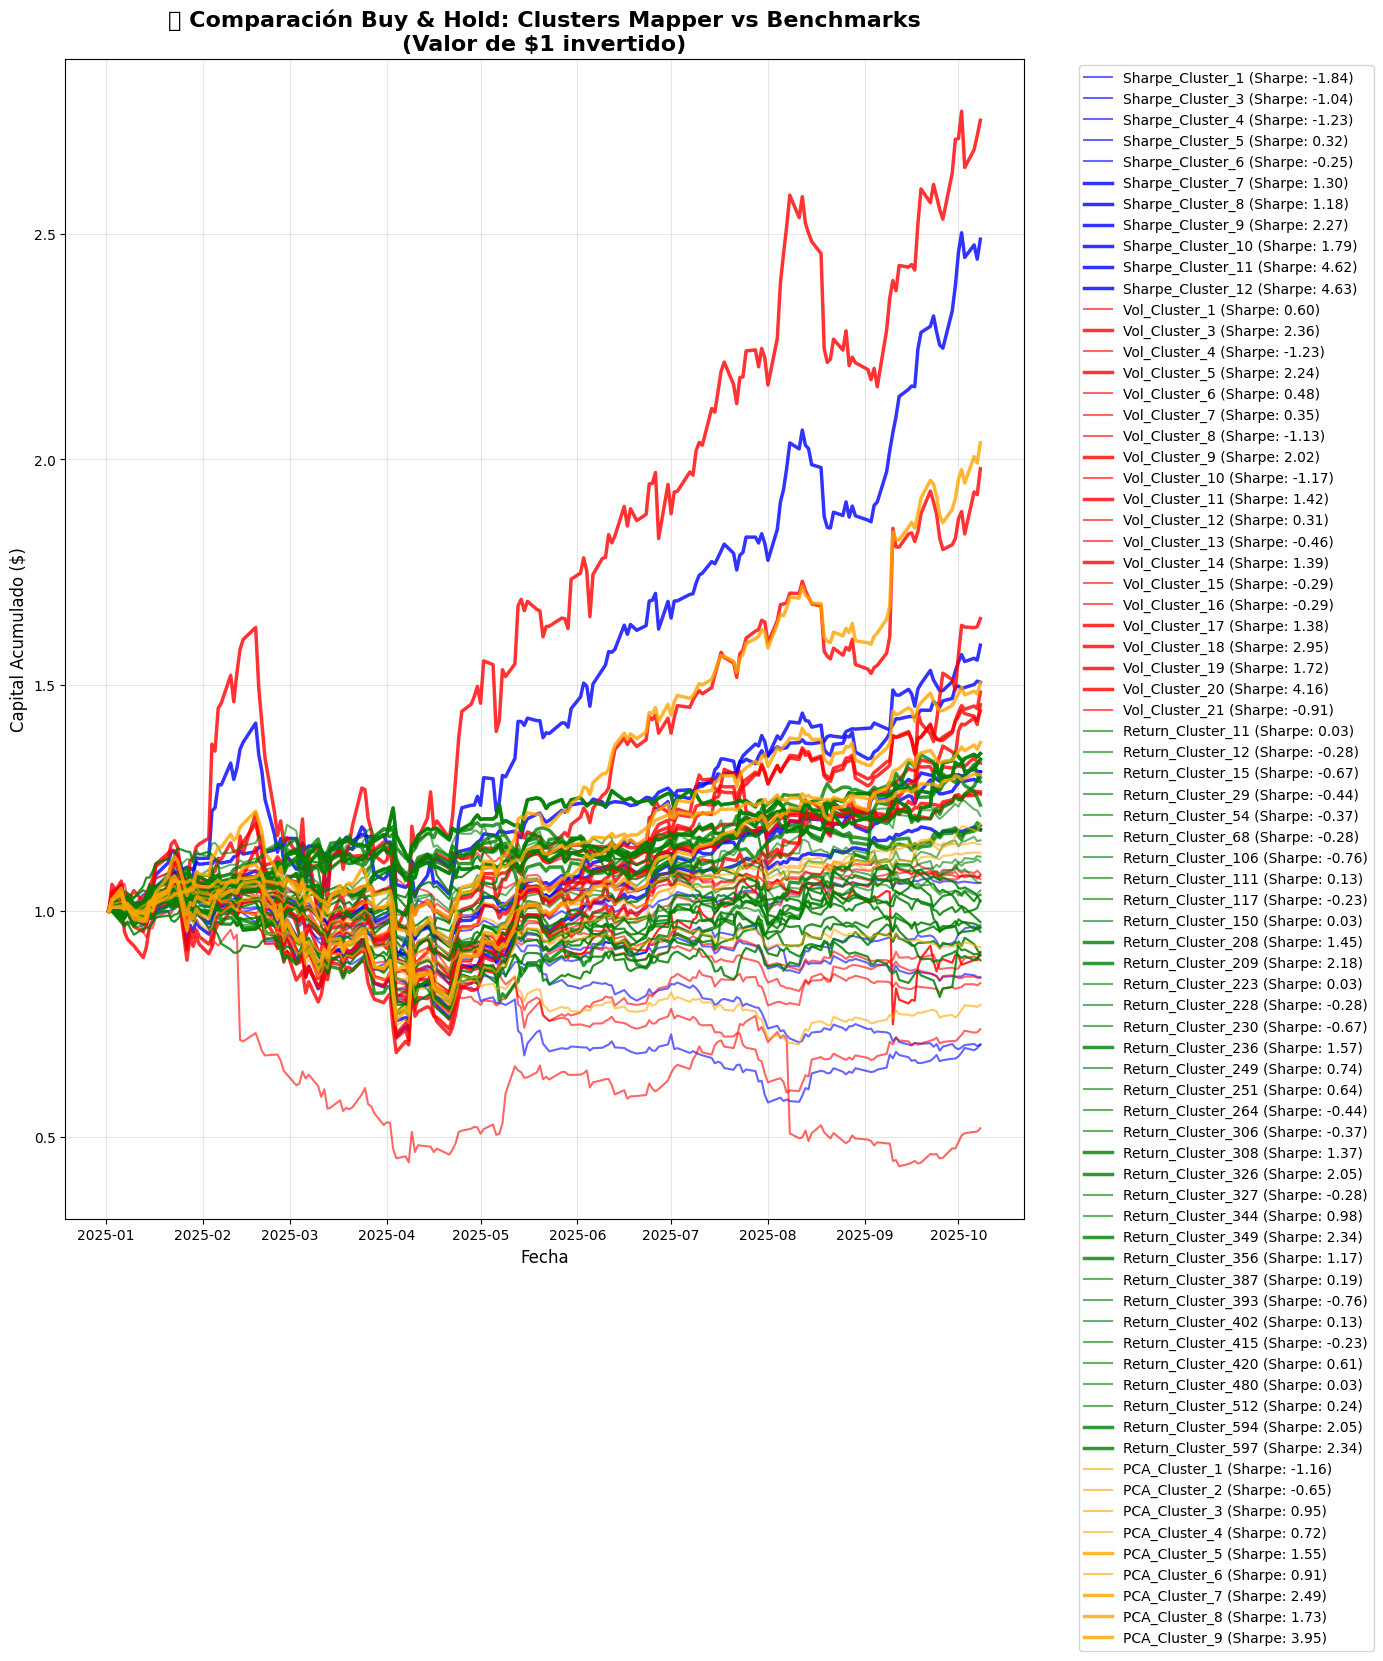


 RANKING DE CLUSTERS POR SHARPE RATIO:
--------------------------------------------------------------------------------
Rank Cluster              Tipo            Sharpe   Retorno    Valor Final 
--------------------------------------------------------------------------------
1    Sharpe_Cluster_12    Sharpe Ratio    4.63     148.782%   $2.488       
2    Sharpe_Cluster_11    Sharpe Ratio    4.62     50.666%    $1.507       
3    Vol_Cluster_20       Volatilidad     4.16     175.114%   $2.751       
4    PCA_Cluster_9        PCA             3.95     103.696%   $2.037       
5    Vol_Cluster_18       Volatilidad     2.95     97.934%    $1.979       
6    PCA_Cluster_7        PCA             2.49     30.235%    $1.302       
7    Vol_Cluster_3        Volatilidad     2.36     25.901%    $1.259       
8    Return_Cluster_349   Retorno Total   2.34     34.875%    $1.349       
9    Return_Cluster_597   Retorno Total   2.34     34.875%    $1.349       
10   Sharpe_Cluster_9     Sharpe Ratio 

In [31]:

# Crear visualización comparativa
if cluster_analysis_results:
    cluster_ranking = create_cluster_comparison_plot(cluster_analysis_results)

In [32]:
# imprimir tickers de cluster especifico por nombre
specific_cluster_name = 'Sharpe_Cluster_11'  # Cambia esto al nombre del cluster que quieres ver
if specific_cluster_name in mapper_clusters:
    specific_cluster_info = mapper_clusters[specific_cluster_name]
    print(f"\n Tickers en {specific_cluster_name}:")
    print(", ".join(specific_cluster_info['tickers']))


 Tickers en Sharpe_Cluster_11:
AEP, BK, CNP, COR, CVS, EVRG, GD, GE, GLW, HCA, HWM, JNJ, LHX, MO, RTX, TEL, TPR, WELL, WRB



 MEJOR CLUSTER IDENTIFICADO: Sharpe_Cluster_12
 Sharpe Ratio: 4.63
 Retorno Total: 148.8%
 ANÁLISIS DETALLADO: Sharpe_Cluster_12


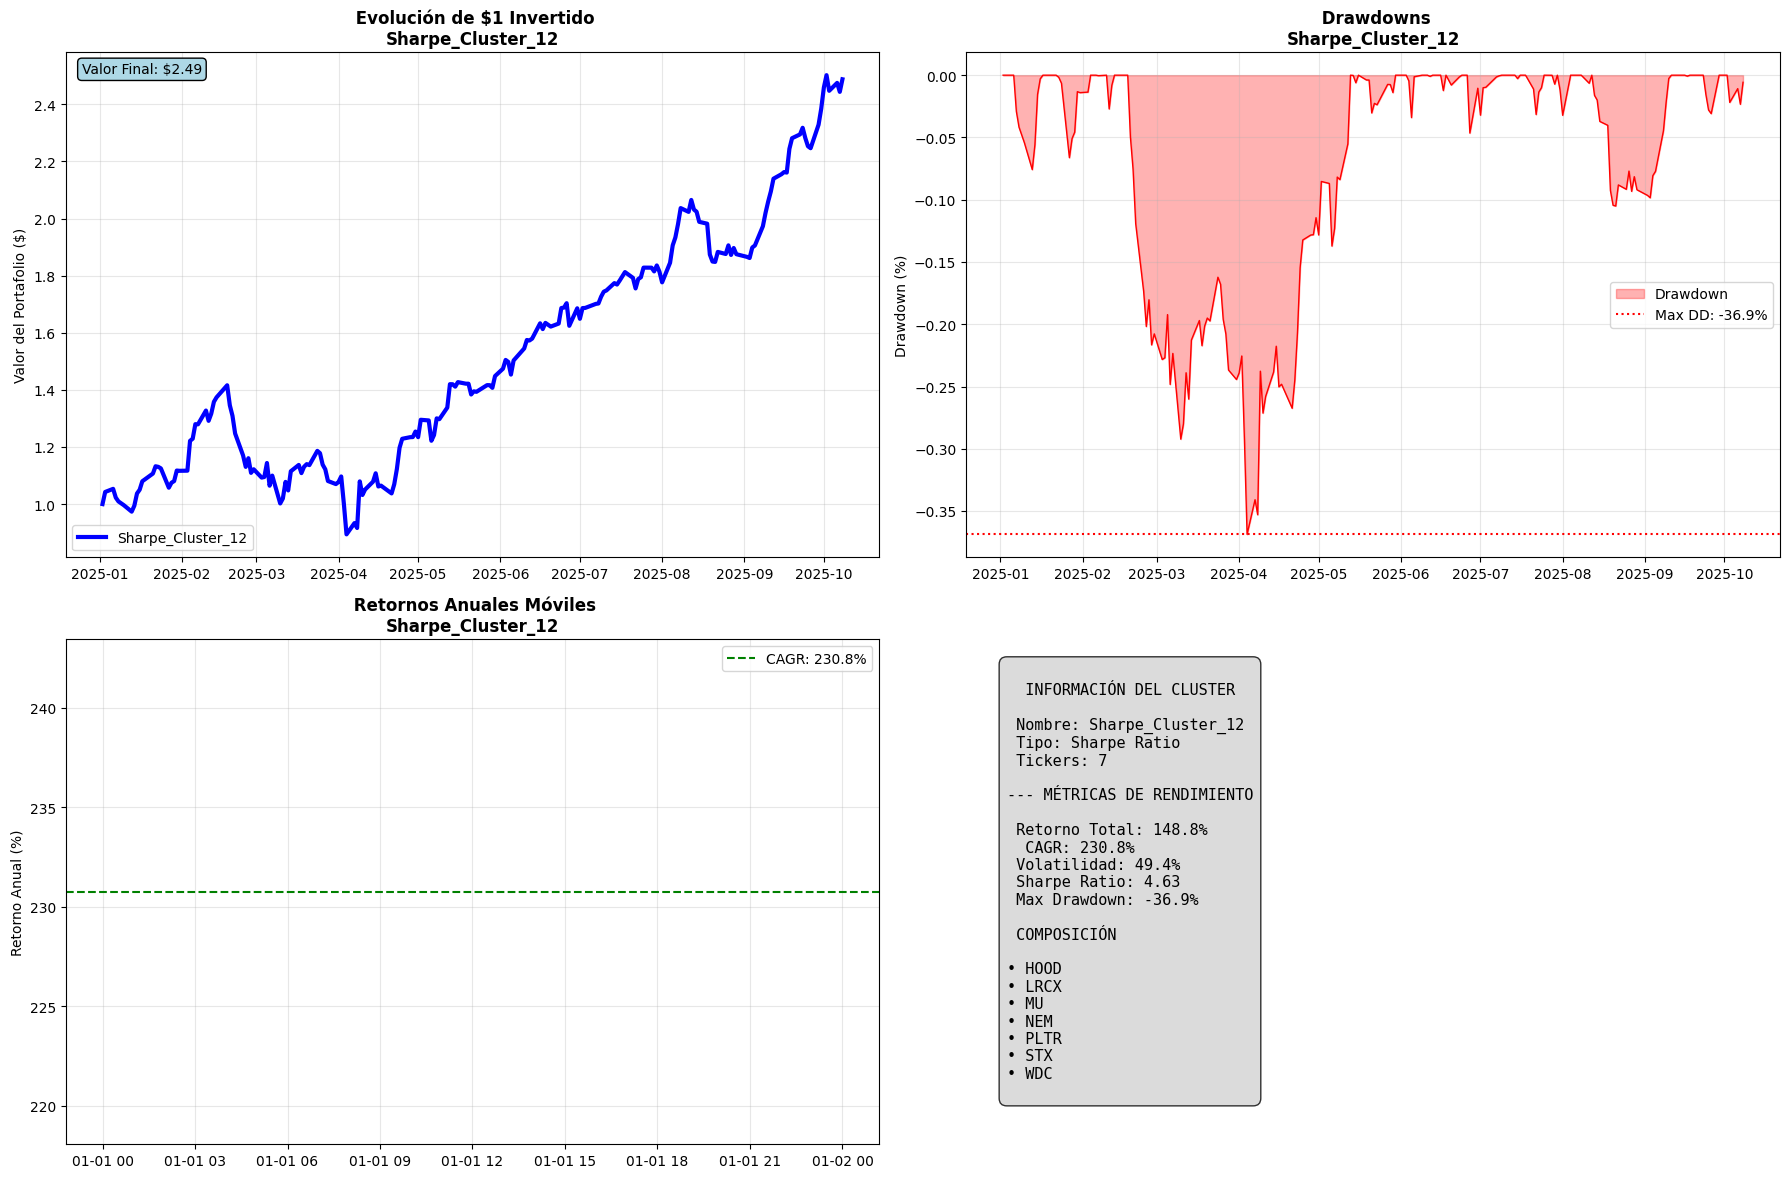


 COMPARACIÓN FINAL: MEJOR CLUSTER VS ÍNDICES PERSONALIZADOS

 MEJOR CLUSTER (Sharpe_Cluster_12):
    Valor Final: $2.49 (de $1 invertido)
    Retorno Total: 148.8%
     Sharpe Ratio: 4.63

 CONCLUSIÓN:
   • El cluster Sharpe_Cluster_12 mostró el mejor rendimiento ajustado por riesgo
   • Basado en agrupación topológica por Sharpe Ratio
   • Compuesto por: HOOD, LRCX, MU, NEM, PLTR, STX, WDC
   • Ideal para construcción de portafolios diversificados

📁 ARCHIVOS GENERADOS POR EL ANÁLISIS MAPPER:
🔸 visualizaciones_mapper_indice/mapper_principal_sharpe.html - Análisis principal por Sharpe Ratio
🔸 visualizaciones_mapper_indice/mapper_interactivo_sharpe.html - Visualización interactiva por Sharpe
🔸 visualizaciones_mapper_indice/mapper_interactivo_volatilidad.html - Visualización por volatilidad
🔸 visualizaciones_mapper_indice/mapper_interactivo_retorno.html - Visualización por retorno
🔸 visualizaciones_mapper_indice/mapper_config_volatilidad.html - Configuración por Volatilidad
🔸 visualizac

In [33]:
# =======================================================
# ANÁLISIS DETALLADO DEL MEJOR CLUSTER
# =======================================================

def create_detailed_cluster_analysis(best_cluster_name, cluster_data, benchmarks=['SPY']):
    """
    Crea análisis detallado del mejor cluster con múltiples visualizaciones
    """
    print(f" ANÁLISIS DETALLADO: {best_cluster_name}")
    print("=" * 60)
    
    cluster_curve = cluster_data['cluster_curve']
    cluster_metrics = cluster_data['cluster_metrics']
    cluster_info = cluster_data['cluster_info']
    
    # Configurar figura con múltiples subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Evolución de capital (superior izquierda)
    ax1.plot(cluster_curve.index, cluster_curve.values, 
             label=f'{best_cluster_name}', color='blue', linewidth=3)
    
    # Añadir benchmarks sincronizados con fecha de inicio del cluster
    cluster_start_date = cluster_curve.index[0]
    for benchmark in benchmarks:
        if benchmark in tickers_data.columns:
            benchmark_data = tickers_data[benchmark].dropna()
            # Filtrar benchmark desde la fecha de inicio del cluster
            benchmark_filtered = benchmark_data[benchmark_data.index >= cluster_start_date]
            if len(benchmark_filtered) > 0:
                benchmark_normalized = (benchmark_filtered / benchmark_filtered.iloc[0]) * 1
                ax1.plot(benchmark_normalized.index, benchmark_normalized.values,
                        label=f'{benchmark}', linestyle='--', linewidth=2)
    
    ax1.set_title(f' Evolución de $1 Invertido\n{best_cluster_name}', fontweight='bold')
    ax1.set_ylabel('Valor del Portafolio ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Añadir texto con valor final
    ax1.text(0.02, 0.98, f'Valor Final: ${cluster_metrics["final_value"]:.2f}', 
             transform=ax1.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue'),
             fontsize=10, verticalalignment='top')
    
    # 2. Drawdowns (superior derecha)
    rolling_max = cluster_curve.expanding().max()
    drawdown = (cluster_curve - rolling_max) / rolling_max
    
    ax2.fill_between(drawdown.index, drawdown.values, 0, 
                     alpha=0.3, color='red', label='Drawdown')
    ax2.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
    ax2.set_title(f' Drawdowns\n{best_cluster_name}', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.axhline(y=cluster_metrics['max_drawdown'], color='red', linestyle=':', 
                label=f'Max DD: {cluster_metrics["max_drawdown"]:.1%}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Retornos anuales móviles (inferior izquierda)
    returns_1y = cluster_curve.pct_change(252) * 100  # retornos anuales móviles
    
    ax3.plot(returns_1y.index, returns_1y.values, color='green', linewidth=2, alpha=0.7)
    ax3.axhline(y=cluster_metrics['cagr']*100, color='green', linestyle='--', 
                label=f'CAGR: {cluster_metrics["cagr"]:.1%}')
    ax3.set_title(f' Retornos Anuales Móviles\n{best_cluster_name}', fontweight='bold')
    ax3.set_ylabel('Retorno Anual (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Composición del cluster (inferior derecha)
    ax4.axis('off')
    
    # Información del cluster
    tickers = cluster_info['tickers']
    cluster_type = cluster_info['type']
    
    # Crear tabla de información
    info_text = f"""
  INFORMACIÓN DEL CLUSTER

 Nombre: {best_cluster_name}
 Tipo: {cluster_type}
 Tickers: {len(tickers)}
    
--- MÉTRICAS DE RENDIMIENTO
    
 Retorno Total: {cluster_metrics['total_return']:.1%}
  CAGR: {cluster_metrics['cagr']:.1%}
 Volatilidad: {cluster_metrics['volatility']:.1%}
 Sharpe Ratio: {cluster_metrics['sharpe']:.2f}
 Max Drawdown: {cluster_metrics['max_drawdown']:.1%}
    
 COMPOSICIÓN
    
{chr(10).join([f'• {ticker}' for ticker in tickers])}
    """
    
    ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Encontrar y analizar el mejor cluster
if cluster_analysis_results:
    # Encontrar el cluster con mejor Sharpe ratio
    best_cluster = max(cluster_analysis_results.items(), 
                      key=lambda x: x[1]['cluster_metrics']['sharpe'])
    best_cluster_name = best_cluster[0]
    best_cluster_data = best_cluster[1]
    
    print(f"\n MEJOR CLUSTER IDENTIFICADO: {best_cluster_name}")
    print(f" Sharpe Ratio: {best_cluster_data['cluster_metrics']['sharpe']:.2f}")
    print(f" Retorno Total: {best_cluster_data['cluster_metrics']['total_return']:.1%}")
    
    # Crear análisis detallado
    create_detailed_cluster_analysis(best_cluster_name, best_cluster_data)
    
    # Comparación final con índices del análisis original
    print(f"\n" + "="*80)
    print(f" COMPARACIÓN FINAL: MEJOR CLUSTER VS ÍNDICES PERSONALIZADOS")
    print(f"="*80)
    
    cluster_final_value = best_cluster_data['cluster_metrics']['final_value']
    cluster_sharpe = best_cluster_data['cluster_metrics']['sharpe']
    cluster_return = best_cluster_data['cluster_metrics']['total_return']
    
    print(f"\n MEJOR CLUSTER ({best_cluster_name}):")
    print(f"    Valor Final: ${cluster_final_value:.2f} (de $1 invertido)")
    print(f"    Retorno Total: {cluster_return:.1%}")
    print(f"     Sharpe Ratio: {cluster_sharpe:.2f}")
    
    # Comparar con benchmarks si están disponibles
    if 'spy_curve' in globals():
        spy_final = (spy_curve.iloc[-1] / spy_curve.iloc[0]) * 1
        print(f"\n VS S&P 500:")
        print(f"    SPY Valor Final: ${spy_final:.2f}")
        print(f"    Ventaja del Cluster: ${cluster_final_value - spy_final:.2f}")
        print(f"    Outperformance: {(cluster_final_value/spy_final - 1):.1%}")
    
    print(f"\n CONCLUSIÓN:")
    print(f"   • El cluster {best_cluster_name} mostró el mejor rendimiento ajustado por riesgo")
    print(f"   • Basado en agrupación topológica por {best_cluster_data['cluster_info']['type']}")
    print(f"   • Compuesto por: {', '.join(best_cluster_data['cluster_info']['tickers'])}")
    print(f"   • Ideal para construcción de portafolios diversificados")

else:
    print("❌ No hay clusters analizados para mostrar")

print(f"\n" + "="*80)
print(f"📁 ARCHIVOS GENERADOS POR EL ANÁLISIS MAPPER:")
print(f"="*80)
print(f"🔸 visualizaciones_mapper_indice/mapper_principal_sharpe.html - Análisis principal por Sharpe Ratio")
print(f"🔸 visualizaciones_mapper_indice/mapper_interactivo_sharpe.html - Visualización interactiva por Sharpe")
print(f"🔸 visualizaciones_mapper_indice/mapper_interactivo_volatilidad.html - Visualización por volatilidad")
print(f"🔸 visualizaciones_mapper_indice/mapper_interactivo_retorno.html - Visualización por retorno")
print(f"🔸 visualizaciones_mapper_indice/mapper_config_volatilidad.html - Configuración por Volatilidad")
print(f"🔸 visualizaciones_mapper_indice/mapper_config_retorno_total.html - Configuración por Retorno Total")
print(f"🔸 visualizaciones_mapper_indice/mapper_config_pca_suma.html - Análisis PCA")
print(f"\n🌐 Para ver las visualizaciones interactivas:")
print(f"   1. Navega a la carpeta 'visualizaciones_mapper_indice/'")
print(f"   2. Abre cualquier archivo .html en tu navegador")
print(f"   3. Explora los clusters haciendo hover sobre los nodos")
print(f"   4. Los nombres de tickers aparecen en los tooltips de cada cluster")